# ReneWind

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 40000 observations in the training set and 10000 in the test set.

The objective is to build various classification models, tune them and find the best one that will help identify failures so that the generator could be repaired before failing/breaking and the overall maintenance cost of the generators can be brought down. 

“1” in the target variables should be considered as “failure” and “0” will represent “No failure”.

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a wind turbine where there is no detection by model. 
- False positives (FP) are detections in a wind turbine where there is no failure. 

So, the maintenance cost associated with the model would be:

**Maintenance cost** = `TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)`
where,

- `Replacement cost = $40,000`
- `Repair cost = $15,000`
- `Inspection cost = $5,000`

Here the objective is to reduce the maintenance cost so, we want a metric that could reduce the maintenance cost.

- The minimum possible maintenance cost  =  `Actual failures*(Repair cost) = (TP + FN)*(Repair cost)`
- The maintenance cost associated with model = `TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)`

So, we will try to maximize the ratio of minimum possible maintenance cost and the maintenance cost associated with the model.

The value of this ratio will lie between 0 and 1, the ratio will be 1 only when the maintenance cost associated with the model will be equal to the minimum possible maintenance cost.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing libraries

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn import metrics, tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.impute import SimpleImputer

## Loading Data

In [3]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [4]:
# Visualizing the train set of data
train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.464606,-4.679129,3.101546,0.506130,-0.221083,-2.032511,-2.910870,0.050714,-1.522351,3.761892,...,3.059700,-1.690440,2.846296,2.235198,6.667486,0.443809,-2.369169,2.950578,-3.480324,0
1,-2.909996,-2.568662,4.109032,1.316672,-1.620594,-3.827212,-1.616970,0.669006,0.387045,0.853814,...,-3.782686,-6.823172,4.908562,0.481554,5.338051,2.381297,-3.127756,3.527309,-3.019581,0
2,4.283674,5.105381,6.092238,2.639922,-1.041357,1.308419,-1.876140,-9.582412,3.469504,0.763395,...,-3.097934,2.690334,-1.643048,7.566482,-3.197647,-3.495672,8.104779,0.562085,-4.227426,0
3,3.365912,3.653381,0.909671,-1.367528,0.332016,2.358938,0.732600,-4.332135,0.565695,-0.101080,...,-1.795474,3.032780,-2.467514,1.894599,-2.297780,-1.731048,5.908837,-0.386345,0.616242,0
4,-3.831843,-5.824444,0.634031,-2.418815,-1.773827,1.016824,-2.098941,-3.173204,-2.081860,5.392621,...,-0.257101,0.803550,4.086219,2.292138,5.360850,0.351993,2.940021,3.839160,-4.309402,0


In [5]:
# Visualizing the test set of data
test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613489,-3.819640,2.202302,1.300420,-1.184929,-4.495964,-1.835817,4.722989,1.206140,-0.341909,...,2.291204,-5.411388,0.870073,0.574479,4.157191,1.428093,-10.511342,0.454664,-1.448363,0
1,-0.732692,2.209513,8.083006,7.062533,-1.510459,-3.260527,-3.333773,-3.018543,3.556598,-1.510685,...,-3.270366,-1.806367,1.797525,5.895108,-1.312278,-0.765156,-1.407807,0.557128,-4.049262,0
2,0.389608,-0.512341,0.527053,-2.576776,-1.016766,2.235112,-0.441301,-4.405744,-0.332869,1.966794,...,-2.474936,2.493582,0.315165,2.059288,0.683859,-0.485452,5.128350,1.720744,-1.488235,0
3,3.412089,1.153345,2.114167,-2.275466,0.087845,-0.009578,0.514235,-1.370917,1.862913,-0.031132,...,-2.496609,-1.776174,-1.712035,-1.506021,2.242186,-0.657637,-1.861584,0.845768,0.857333,0
4,-0.874861,-0.640632,4.084202,-1.590454,0.525855,-1.957592,-0.695367,1.347309,-1.732348,0.466500,...,-1.318888,-2.997464,0.459664,0.619774,5.631504,1.323512,-1.752154,1.808302,1.675748,0


In [6]:
print('The shape of the training data is: ',train.shape)
print('The shape of the test data is: ',test.shape)

The shape of the training data is:  (40000, 41)
The shape of the test data is:  (10000, 41)


## EDA and insights

In [7]:
train.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,39954.000000,39961.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,...,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,-0.288120,0.442672,2.505514,-0.066078,-0.044574,-1.000849,-0.892793,-0.563123,-0.007739,-0.001848,...,0.326831,0.056542,-0.464127,2.234861,1.530020,-0.000498,-0.351199,0.900035,-0.897166,0.054675
std,3.449072,3.139431,3.406263,3.437330,2.107183,2.036756,1.756510,3.298916,2.161833,2.183034,...,5.499369,3.574219,3.185712,2.924185,3.819754,1.778273,3.964186,1.751022,2.997750,0.227348
min,-13.501880,-13.212051,-11.469369,-16.015417,-8.612973,-10.227147,-8.205806,-15.657561,-8.596313,-11.000790,...,-23.200866,-17.454014,-17.985094,-15.349803,-17.478949,-7.639952,-17.375002,-7.135788,-11.930259,0.000000
25%,-2.751460,-1.638355,0.202682,-2.349574,-1.507206,-2.363446,-2.036913,-2.660415,-1.493676,-1.390549,...,-3.392115,-2.237550,-2.127757,0.332081,-0.937119,-1.265717,-3.016805,-0.261578,-2.949590,0.000000
50%,-0.773518,0.463939,2.265319,-0.123691,-0.096824,-1.006635,-0.934738,-0.384188,-0.052085,0.105779,...,0.056243,-0.049729,-0.250842,2.110125,1.571511,-0.132620,-0.318724,0.921321,-0.949269,0.000000
75%,1.836708,2.537508,4.584920,2.148596,1.346224,0.373909,0.206820,1.714383,1.425713,1.486105,...,3.789241,2.255985,1.432885,4.044659,3.996721,1.160828,2.291342,2.069016,1.092178,0.000000
max,17.436981,13.089269,18.366477,13.279712,9.403469,7.065470,8.006091,11.679495,8.507138,8.108472,...,24.847833,16.692486,14.358213,16.804859,19.329576,7.803278,15.964053,7.997832,10.654265,1.000000


In [8]:
test.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,9989.000000,9993.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.259840,0.416733,2.555405,-0.053760,-0.084812,-1.013953,-0.908349,-0.598872,0.025751,0.019366,...,0.252823,0.008231,-0.422751,2.258233,1.550037,-0.006080,-0.372647,0.919934,-0.936516,0.054700
std,3.440139,3.159640,3.394924,3.462312,2.101944,2.039330,1.736721,3.342703,2.180268,2.168894,...,5.503483,3.551973,3.167615,2.919060,3.794208,1.782281,3.997659,1.726064,3.011183,0.227405
min,-12.381696,-11.625356,-12.940616,-14.682446,-7.711569,-8.949383,-8.124230,-12.710064,-7.570282,-8.290688,...,-20.520063,-14.903781,-17.134528,-19.522334,-14.912346,-5.361838,-15.334533,-7.147175,-10.779061,0.000000
25%,-2.700080,-1.701281,0.238184,-2.371381,-1.592551,-2.376522,-2.034983,-2.684187,-1.490342,-1.362190,...,-3.458870,-2.280224,-2.065867,0.374931,-0.891950,-1.277895,-3.003846,-0.225239,-2.993471,0.000000
50%,-0.719224,0.456278,2.282670,-0.168953,-0.143658,-1.014574,-0.938351,-0.387062,-0.086089,0.149634,...,-0.013262,-0.099140,-0.203423,2.149482,1.619817,-0.150051,-0.361915,0.933255,-0.986149,0.000000
75%,1.860839,2.526054,4.656206,2.144304,1.323820,0.353990,0.189024,1.698392,1.465928,1.537166,...,3.761548,2.197857,1.472123,4.088103,4.061276,1.193239,2.334558,2.097337,1.084677,0.000000
max,13.504352,14.079073,15.408963,12.895544,7.672835,6.272818,7.616182,10.791916,8.850720,7.691455,...,26.539391,13.323517,14.581285,13.489237,17.116122,7.681837,13.725888,7.233951,10.391602,1.000000


In [9]:
#Checking for missing values
print("\nMissing Values in Train set")
print(train.isnull().sum())


Missing Values in Train set
V1        46
V2        39
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64


In [10]:
print("\nMissing Values in Test set")
print(test.isnull().sum())


Missing Values in Test set
V1        11
V2         7
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64


In [11]:
train[train.isnull().any(axis=1)]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
179,NaN,-3.961403,2.787804,-4.712526,-3.007329,-1.541245,-0.881148,1.476656,0.574700,-1.100884,...,-8.326069,-5.140552,1.121314,-0.305907,5.315007,3.750044,-5.631174,2.372485,2.195956,0
273,8.340257,NaN,4.701014,-6.210458,-3.452383,1.470407,1.363145,-3.737388,2.563769,0.580317,...,-9.074177,0.302138,-1.629747,1.621417,1.755205,-1.708377,-1.411025,1.290293,0.752315,0
1245,-2.048681,NaN,-1.623885,-3.324224,0.152256,0.600157,-1.812802,0.852194,-1.522600,0.211071,...,3.264218,2.379064,-2.457084,1.719365,2.537010,1.701780,-1.434535,0.597365,0.739238,0
1380,-5.418573,NaN,-3.572559,5.968870,-0.205538,-1.109785,-0.932011,3.405683,-1.115739,0.522278,...,4.859093,0.336079,3.993229,-0.140748,-3.344090,0.364732,-1.402871,-1.717696,-2.597330,1
1912,NaN,-4.396035,2.966584,0.295102,0.731237,-1.994700,-3.058456,1.751438,-0.829251,1.678691,...,3.066807,0.169947,1.215512,-0.164512,6.554772,1.116389,-5.987598,2.751352,-1.781519,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36733,-2.377369,NaN,-0.009173,-1.471979,1.295482,0.724894,-1.122797,-3.190475,3.250575,-4.861648,...,-5.093149,0.439355,-3.167241,-2.713266,-0.592845,3.229219,1.315635,2.282838,1.151589,0
37469,3.318285,NaN,4.764121,0.239790,-2.088341,-1.334183,-1.326659,-1.931971,0.876763,0.348388,...,-2.227943,-1.213178,-0.208744,5.786150,0.718919,-0.701807,-0.134913,0.211544,-1.405950,0
37815,-0.119181,NaN,3.657612,-1.231802,1.946873,-0.119089,0.652414,-1.490208,-0.033631,-2.556604,...,-4.670353,-0.593916,-1.650592,-1.405071,1.531267,1.079147,2.832949,1.450781,3.232659,0
38038,NaN,5.469351,3.925862,7.075116,-0.581082,-5.171569,1.415715,1.564463,-1.076731,0.971791,...,7.125148,-1.795369,2.989587,8.169314,-3.717625,-3.768507,2.539606,-1.295166,-6.938777,1


In [12]:
test[test.isnull().any(axis=1)]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
1081,NaN,-1.040280,6.532031,-3.000840,-2.063332,-1.666057,-0.337674,-1.132146,-0.684761,2.505069,...,-3.676092,-2.199322,1.401676,3.757154,5.738659,-0.774900,-1.497083,2.532995,-1.179080,0
1384,3.171300,NaN,-0.899604,-7.687193,-1.844379,2.229502,0.649609,0.680742,-0.079613,-3.926869,...,-8.569958,1.198974,-3.747194,-0.834087,0.364598,3.687177,-1.450631,-0.012682,6.569833,0
1494,NaN,2.120750,1.027513,1.538515,4.017318,-0.897504,-3.188425,-0.826265,0.036000,-1.225102,...,10.290862,5.641290,-5.354804,2.754283,1.446048,-0.331293,-0.555928,0.980866,-2.225800,0
1706,NaN,1.481190,2.208128,-2.550029,1.526045,-0.964918,0.559579,3.004337,-3.937734,0.105693,...,5.093845,2.920339,-3.080601,3.750633,2.422388,-0.692277,-0.182557,-0.709241,2.498946,0
2155,NaN,1.222743,7.023517,-1.227970,-3.385548,-1.500321,-0.375947,-2.898488,3.016750,0.097183,...,-6.401373,-2.539566,-0.427894,4.971210,1.229448,-1.620576,-2.472413,0.692331,-1.427785,0
3330,NaN,-5.280584,1.695313,-0.787160,-1.872912,-0.469312,-1.970327,-2.099606,-1.573940,4.521625,...,-1.939828,-2.575771,5.279322,1.557176,5.542348,1.058056,1.696663,3.691808,-3.802066,0
3619,1.255877,NaN,1.123121,0.347719,-0.199314,0.542522,-0.904536,-2.398356,0.228689,0.245489,...,0.851358,1.657839,-1.410919,3.587088,-1.116910,-0.865736,2.766820,-0.368560,-0.864084,0
3731,NaN,-0.558554,5.315575,1.517019,-2.304035,-1.410233,-1.974341,-3.081827,1.762233,1.134216,...,-3.017435,-0.475546,1.987185,4.541473,1.335494,-0.812582,-0.545365,1.922588,-4.117640,0
3795,-1.272832,NaN,4.426359,-3.013970,-1.294693,-0.883173,-1.731633,0.098774,-0.991360,2.495756,...,-0.396983,1.190134,0.629071,2.411258,6.166668,-0.140616,-4.208798,2.623088,-1.368893,0
5541,-2.938927,NaN,2.913242,1.431121,4.003345,-4.743048,-2.450111,3.795883,-0.339877,-2.897700,...,12.077656,0.671770,-6.354040,3.887011,3.420416,0.506994,-5.913055,0.214129,-0.931294,0


There are 85 data points in the train set at 18 in the test set that contain null values. The cipher may not have worked properly to encode the data. We will have to deal with these missing values later.

In [13]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      39954 non-null  float64
 1   V2      39961 non-null  float64
 2   V3      40000 non-null  float64
 3   V4      40000 non-null  float64
 4   V5      40000 non-null  float64
 5   V6      40000 non-null  float64
 6   V7      40000 non-null  float64
 7   V8      40000 non-null  float64
 8   V9      40000 non-null  float64
 9   V10     40000 non-null  float64
 10  V11     40000 non-null  float64
 11  V12     40000 non-null  float64
 12  V13     40000 non-null  float64
 13  V14     40000 non-null  float64
 14  V15     40000 non-null  float64
 15  V16     40000 non-null  float64
 16  V17     40000 non-null  float64
 17  V18     40000 non-null  float64
 18  V19     40000 non-null  float64
 19  V20     40000 non-null  float64
 20  V21     40000 non-null  float64
 21  V22     40000 non-null  float64
 22

In [14]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      9989 non-null   float64
 1   V2      9993 non-null   float64
 2   V3      10000 non-null  float64
 3   V4      10000 non-null  float64
 4   V5      10000 non-null  float64
 5   V6      10000 non-null  float64
 6   V7      10000 non-null  float64
 7   V8      10000 non-null  float64
 8   V9      10000 non-null  float64
 9   V10     10000 non-null  float64
 10  V11     10000 non-null  float64
 11  V12     10000 non-null  float64
 12  V13     10000 non-null  float64
 13  V14     10000 non-null  float64
 14  V15     10000 non-null  float64
 15  V16     10000 non-null  float64
 16  V17     10000 non-null  float64
 17  V18     10000 non-null  float64
 18  V19     10000 non-null  float64
 19  V20     10000 non-null  float64
 20  V21     10000 non-null  float64
 21  V22     10000 non-null  float64
 22 

All values are either an integer or float so no tranformations will need to be done in this regard

#### Univariate and Bivariate Data Analysis

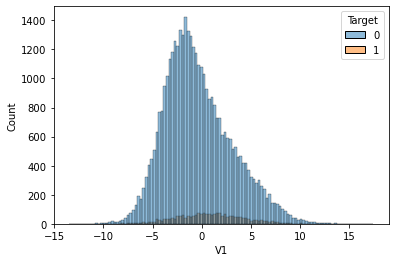

In [15]:
sns.histplot(x='V1',data=train,hue='Target');

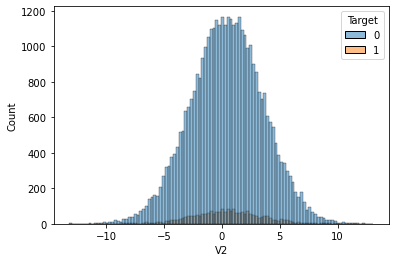

In [16]:
sns.histplot(x='V2',data=train,hue='Target');

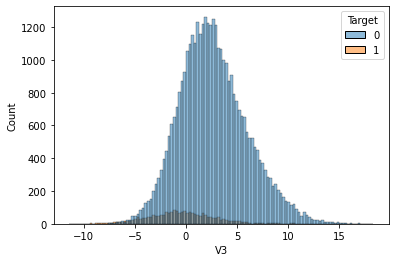

In [17]:
sns.histplot(x='V3',data=train,hue='Target');

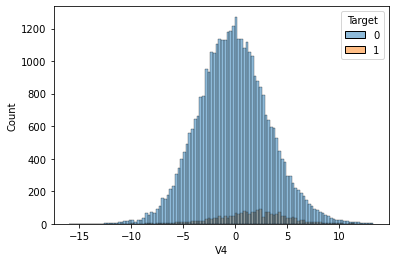

In [18]:
sns.histplot(x='V4',data=train,hue='Target');

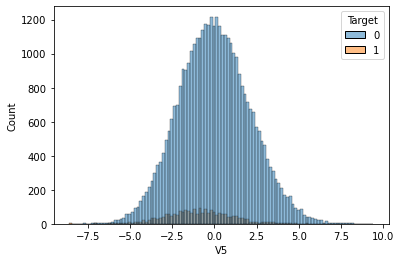

In [19]:
sns.histplot(x='V5',data=train,hue='Target');

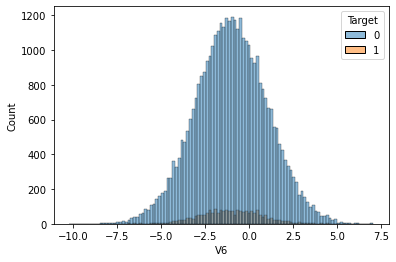

In [20]:
sns.histplot(x='V6',data=train,hue='Target');

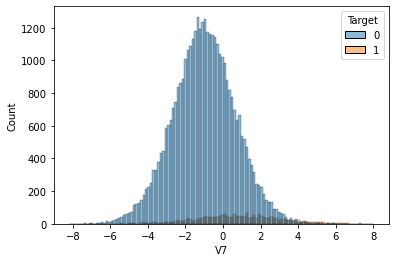

In [21]:
sns.histplot(x='V7',data=train,hue='Target');

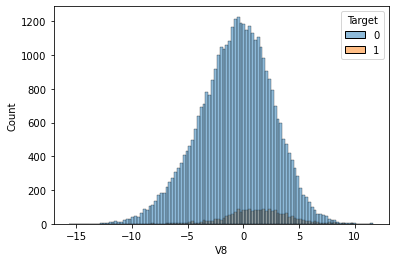

In [22]:
sns.histplot(x='V8',data=train,hue='Target');

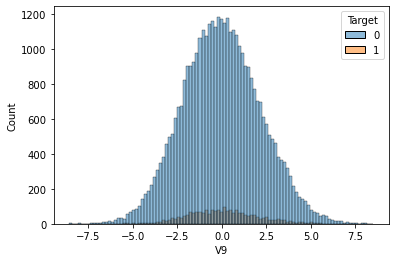

In [23]:
sns.histplot(x='V9',data=train,hue='Target');

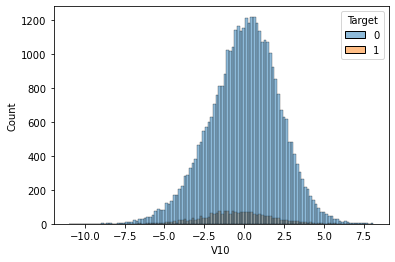

In [24]:
sns.histplot(x='V10',data=train,hue='Target');

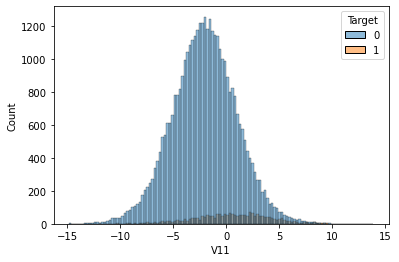

In [25]:
sns.histplot(x='V11',data=train,hue='Target');

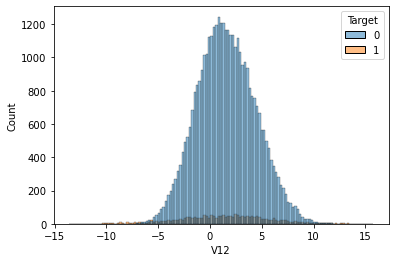

In [26]:
sns.histplot(x='V12',data=train,hue='Target');

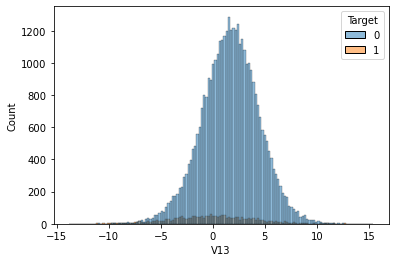

In [27]:
sns.histplot(x='V13',data=train,hue='Target');

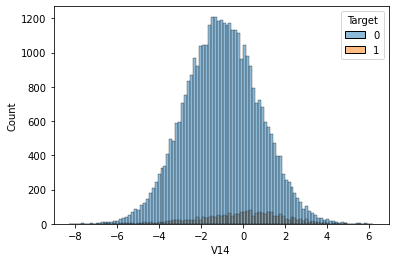

In [28]:
sns.histplot(x='V14',data=train,hue='Target');

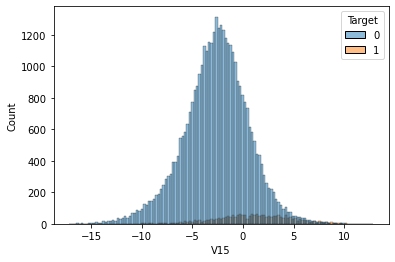

In [29]:
sns.histplot(x='V15',data=train,hue='Target');

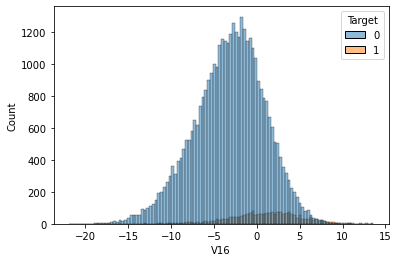

In [30]:
sns.histplot(x='V16',data=train,hue='Target');

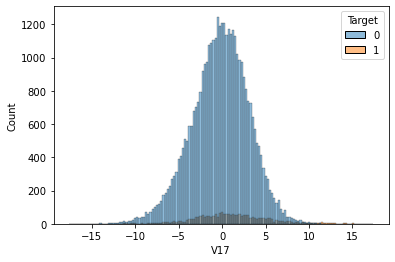

In [31]:
sns.histplot(x='V17',data=train,hue='Target');

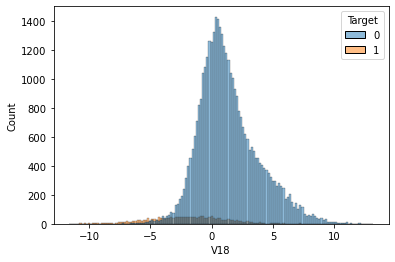

In [32]:
sns.histplot(x='V18',data=train,hue='Target');

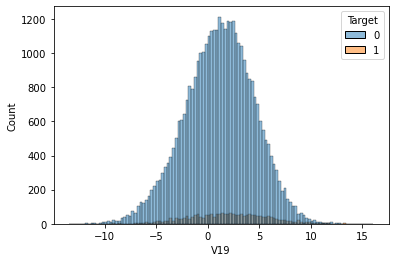

In [33]:
sns.histplot(x='V19',data=train,hue='Target');

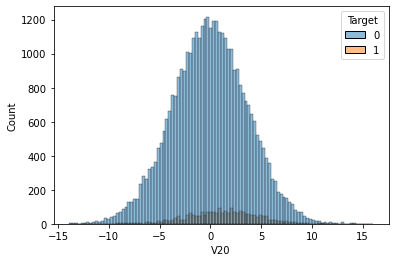

In [34]:
sns.histplot(x='V20',data=train,hue='Target');

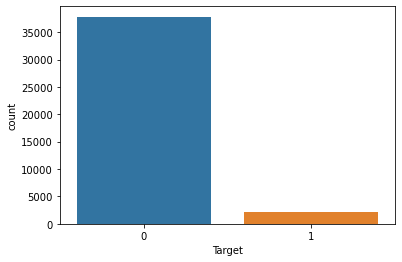

In [35]:
sns.countplot(x='Target',data=train);

##### Observations
* Looking through the data, all instances of the independent variables seem to be normally distributed. As such no transformation needs to be done about the data. 

* There is a large disparency between the incidence of data that has target=0 and the incedence that has target=1.

* We can also see from the graphs which variables have different values based on the result of the target. For the vairables V1, V3, V4, V5, V7, V8, V11, V13, V14, V15, V16, V18, V20 there seems to be a difference between the mean value of the distribution when the target variable is 0 versus 1. These are likely to have some importance to the overall model. 



## Data Pre-processing

##### Missing Value Treatment

To deal with the missing values identified above we will replace the NA's with the mean of the column.

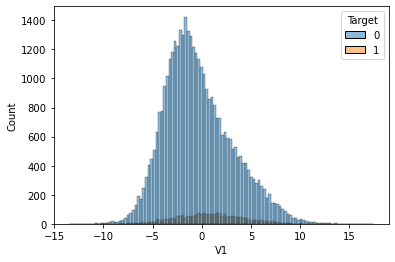

In [36]:
#Replacing all NAs with the mean in both the train and the test dataset
train['V1']=train['V1'].replace(np.nan, train.V1.mean())
train['V2']=train['V2'].replace(np.nan, train.V2.mean())

test['V1']=test['V1'].replace(np.nan, test.V1.mean())
test['V2']=test['V2'].replace(np.nan, test.V2.mean())

# Reviewing the distribution of V1 
sns.histplot(x='V1',data=train,hue='Target');

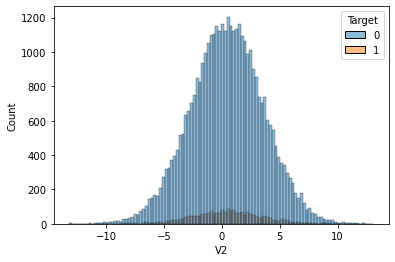

In [37]:
# Reviewing the distribution of V2 
sns.histplot(x='V2',data=train,hue='Target');

## Model evaluation criterion

### 3 types of cost are associated with the provided problem
1. Replacement cost - False Negatives - Predicting no failure, while there will be a failure
2. Inspection cost - False Positives - Predicting failure, while there is no failure 
3. Repair cost - True Positives - Predicting failure correctly

### How to reduce the overall cost?
* We need to create a customized metric, that can help to bring down the overall cost.
* The cost associated with any model = TP * 15000 + FP * 5000 + FN * 40000
* And the minimum possible cost will be when, the model will be able to identify all failures, in that case, the cost will be (TP + FN) * 15000
* So, we will try to maximize `Minimum cost/Cost associated with model`

**Let's create two functions to calculate different metrics and confusion matrix, so that we don't have to use the same code repeatedly for each model.**

In [38]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    TP = metrics.confusion_matrix(target, model.predict(predictors))[1, 1]
    FP = metrics.confusion_matrix(target, model.predict(predictors))[0, 1]
    FN = metrics.confusion_matrix(target, model.predict(predictors))[1, 0]
    Cost = TP * 15 + FP * 5 + FN * 40  # maintenance cost by using model
    Min_Cost = (TP + FN) * 15  # minimum possible maintenance cost = number of actual positives
    Percent = Min_Cost / Cost  # ratio of minimum possible maintenance cost and maintenance cost by model

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
            "Minimum_Vs_Model_cost": Percent,
        },
        index=[0],
    )

    return df_perf

In [39]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = metrics.confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## **Defining scorer to be used for hyperparameter tuning**

- Every prediction of a classification model will be either a TP, FP, FN or TN.
- Till now at most of the places we wanted to reduce False negatives and hence we tried to maximize "Recall".
- To maximize Recall, we used Recall as a **scorer** in hyperparameter tuning.
- Here, we not only want to minimize false negatives but also false positives and we are also given the costs associated with each type of prediction.
- So, overall we want to reduce the maintenance cost which is: `TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)`
- In simple language, we can say that we are assigning different weightage to the different types of predictions.
- Do we have any such metric which can help us minimize the maintenance cost? i.e., help us reduce FP and FN as per the weightage - We don't have any such inbuilt metric.
- In sklearn, we can define **custom scorers** also as per our need.
- For this classification problem, we need to reduce the maintenance cost, which can be reiterated as:
  - Minimize (maintenance cost)
  - Maximize (1/maintenance cost)
  - Maximize (minimum possible maintenance cost/maintenance cost)
- Eventually, all 3 metrics will do the same work in the backend and the only difference will be in the scale of the values of the metric.

- The metric provided in the next cell is to `maximize(minimum possible maintenance cost/maintenance cost)`
- You can modify the metric as per convenience and use it further to tune the models.

In [40]:
# defining metric to be used for optimization and with cross-validation
def Minimum_Vs_Model_cost(y_train, y_pred):
    """
    We want the model to optimize the maintenance cost and reduce it to the lowest possible value.
    The lowest possible maintenance cost will be achieved when each sample is predicted correctly.

    In such a scenario, the maintenance cost will be the total number of failures times the maintenance cost of replacing one generator,
    which is given by (TP + FN) * 40 (i.e., the actual positives*40).
    For any other scenario,
    the maintenance cost associated with the model will be given by (TP * 15 + FP * 5 + FN * 40).

    We will use the ratio of these two maintenance costs as the cost function for our model.
    The greater the ratio, the lower the associated maintenance cost and the better the model.
    """
    TP = metrics.confusion_matrix(y_train, y_pred)[1, 1]
    FP = metrics.confusion_matrix(y_train, y_pred)[0, 1]
    FN = metrics.confusion_matrix(y_train, y_pred)[1, 0]
    return ((TP + FN) * 15) / (TP * 15 + FP * 5 + FN * 40)


# A value of .80 here, will represent that the minimum maintenance cost is 80% of the maintenance cost associated with the model.
# Since minimum maintenance cost is constant for any data, when minimum cost will become 100% of maintenance cost associated with the model
# Model will have give the least possible maintenance cost.


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Higher the values, the lower the maintenance cost

## Model Building with Original data

In [41]:
#Defining our dependent variable,y as target, and independent variables.
x = train.drop('Target',axis=1)
y = train.pop('Target')


#Splitting the train data into a train and validate set using a 80-20 split
X_train,X_validate,y_train,y_validate = train_test_split(x,y, test_size=0.2,random_state=1)

In [42]:
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in validate data =", X_validate.shape[0])
print("\nDistribution of target data in the train set:")
print(round(y_train.value_counts(normalize=True),3)*100)
print("Distribution of target data in the validation set:")
print(round(y_validate.value_counts(normalize=True),3)*100)

Number of rows in train data = 32000
Number of rows in validate data = 8000

Distribution of target data in the train set:
0    94.5
1     5.5
Name: Target, dtype: float64
Distribution of target data in the validation set:
0    94.6
1     5.4
Name: Target, dtype: float64


The distribution of the target data in the train and validation sets is about the same, but as displayed through the EDA, very little data is present for target=1

In [43]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic Regression",LogisticRegression()))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models

# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Training Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = Minimum_Vs_Model_cost(y_train, model.predict(X_train)) * 100
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

Logistic Regression: 52.581817062057546
Bagging: 68.67369938257175
Random forest: 71.51243120148332
GBM: 67.49182683337902
Adaboost: 59.585835361184195
Xgboost: 76.6090152145775
dtree: 65.2454267353064

Training Performance:

Logistic Regression: 52.599540963975656
Bagging: 93.40776182881446
Random forest: 99.90523123578468
GBM: 72.96511627906976
Adaboost: 60.32272831311513
Xgboost: 100.0
dtree: 100.0


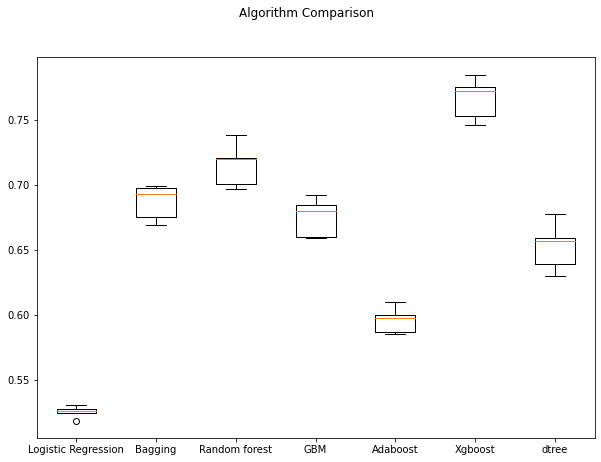

In [44]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

* The best performing model based on cross-validated performance is the XGBoost, followed by the Random Forest and Decision Tree.

* The best performance on the validation data set was also from teh XGBoost model, followed by the Random Forest and then the Bagging Classifier.

* The Logistic Regression model displayed the worst performance in both cases.

## Model Building with Oversampled data


In [45]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [46]:
print("The size of the oversampled data is: ")
print(X_train_over.shape[0])
print("\nDistribution of target data in the oversampled data:")
print(round(y_train_over.value_counts(normalize=True),3)*100)

The size of the oversampled data is: 
60486

Distribution of target data in the oversampled data:
0    50.0
1    50.0
Name: Target, dtype: float64


* The number of data points in the train set has increased from 32,000 to 60,486.
* The percentage of data with target=0 has increased relative to the data set significantly, moving from just over 5% to 50%.
* The data is now evenly split among the target variables

In [47]:
# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")
for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))



Cross-Validation Performance:

Logistic Regression: 79.16923754435447
Bagging: 95.49511639836963
Random forest: 96.98605943097688
GBM: 86.65998718924108
Adaboost: 82.69082503518067
Xgboost: 97.13344421672303
dtree: 93.59667324986829


In [48]:
print("\n" "Training Performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = Minimum_Vs_Model_cost(y_train_over, model.predict(X_train_over)) * 100
    print("{}: {}".format(name, scores))


Training Performance:

Logistic Regression: 79.2330733828782
Bagging: 99.67371959659877
Random forest: 100.0
GBM: 87.09036456833496
Adaboost: 82.9302402105956
Xgboost: 99.72521131250069
dtree: 100.0


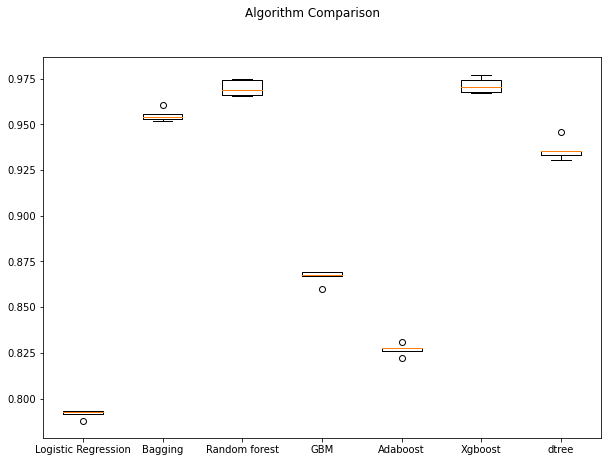

In [49]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results[7:])
ax.set_xticklabels(names[7:])

plt.show()

* There is significant improvement in the cross-validated performance for all models.
* XGBoost continues to show the best performance but the performance of the Random Forest improved enough to be on par with that of the XGBoost model.
* The Logistic Regression model still has the worst performance of the lot.

## Model Building with Undersampled data

In [50]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [51]:
print("The size of the undersampled data is: ")
print(X_train_un.shape[0])
print("\nDistribution of target data in the undersampled data:")
print(round(y_train_un.value_counts(normalize=True),3)*100)

The size of the undersampled data is: 
3514

Distribution of target data in the undersampled data:
0    50.0
1    50.0
Name: Target, dtype: float64


* From under sampling the size of the data has been reduced from 32,000 entries to 3,514.
* Similar to oversampling, the data is now evenly split based on the result of the target variable.

In [60]:
print("\n" "Cross-Validation Performance:" "\n")
for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))


Cross-Validation Performance:

Logistic Regression: 77.15956539194137
Bagging: 81.15248240157335
Random forest: 84.54913330148874
GBM: 83.03085250320338
Adaboost: 78.63665758679524
Xgboost: 84.36139736390558
dtree: 77.85438355759557


In [53]:
print("\n" "Training Performance:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = Minimum_Vs_Model_cost(y_train_un, model.predict(X_train_un)) * 100
    print("{}: {}".format(name, scores))


Training Performance:

Logistic Regression: 76.91521961184883
Bagging: 96.83997795333455
Random forest: 100.0
GBM: 87.15277777777779
Adaboost: 81.80971597082105
Xgboost: 100.0
dtree: 100.0


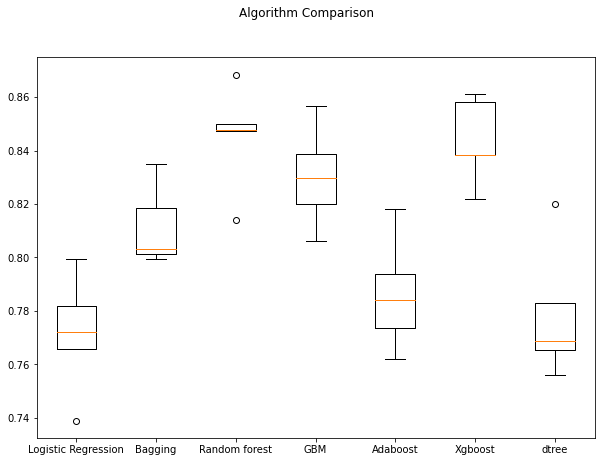

In [61]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results[21:])
ax.set_xticklabels(names[21:])

plt.show()

* XGBoost continues to perform the best followed by Random Forest and Bagging models.
* Performance of the validation set lags the cross-validated scores all around. 

## Model Selection

We will tune the XGBoost, Random Forest and Bagging Classifier Models, as all three recorded the highest scores in all three scenarios and therefore would be expected to perform the best.
We will use the oversampled data to tune the model.

## HyperparameterTuning 

- **Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

#### For XGBoost:
param_grid={'n_estimators':np.arange(150,300,50),'scale_pos_weight':[5,10],
            'learning_rate':[0.1,0.2], 'gamma':[0,3,5],
            'subsample':[0.8,0.9]}

#### For Gradient Boosting:
param_grid = {
    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "n_estimators": np.arange(75,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]}


#### For Adaboost:
param_grid = {
    "n_estimators": np.arange(10, 110, 20),
    "learning_rate": [ 0.2, 0.05, 1],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1)]}

#### For logistic Regression:
param_grid = {'C': np.arange(0.1,1.1,0.1)}

#### For Bagging Classifier:
param_grid = {
              'max_samples': [0.8,0.9], 
              'max_features': [0.8,0.9],
              'n_estimators' : [40,50]}

#### For Random Forest:
param_grid = {
    "n_estimators": [150,250],
    "min_samples_leaf": np.arange(1, 3),
    "max_features": ['sqrt','log2'],
    "max_samples": np.arange(0.2, 0.6, 0.1)}

#### For Decision Trees:
param_grid = {'max_depth': np.arange(2,20), 
              'min_samples_leaf': [1, 2, 5, 7],
              'max_leaf_nodes' : [5, 10,15],
              'min_impurity_decrease': [0.0001,0.001]
             }

In [86]:
%%time 
import warnings
warnings.filterwarnings("ignore")
# defining model
model = XGBClassifier(random_state=1)

# Parameter grid to pass in GridSearchCV
param_grid={'n_estimators':np.arange(150,300,50),
            'scale_pos_weight':[5,10],
            'learning_rate':[0.1,0.2], 'gamma':[0,3,5],
            'subsample':[0.8,0.9]}

# Calling GridSearchCV
grid_cv = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                             scoring=scorer,n_iter = 5, cv=2, 
                             random_state=1)

# Fitting parameters in GridSearchCV
grid_cv.fit(X_train_over, y_train_over)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)

[02:32:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:32:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:32:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:32:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [90]:
xgb_tuned1 = XGBClassifier(
    subsample=0.9 ,
    scale_pos_weight=10 ,
    n_estimators=100,
    random_state=1,
    learning_rate = 0.2 ,
    gamma = 0)

# Fit the model on training data
xgb_tuned1.fit(X_train, y_train)

[02:35:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [91]:
#Calculating the different metrics on the train data set
xgb_random_train = model_performance_classification_sklearn(
    xgb_tuned1, X_train, y_train
)
print('Training Performance: ')
print(xgb_random_train)
#Calculating the different metrics on the validation data set
xgb_val_perf = model_performance_classification_sklearn(xgb_tuned1,
                                                       X_validate,y_validate)
print("\nValidation performance:")
print(xgb_val_perf)

Training Performance: 
   Accuracy  Recall  Precision        F1  Minimum_Vs_Model_cost
0  0.999594     1.0   0.992655  0.996314                0.99754

Validation performance:
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0   0.99075  0.872093   0.951777  0.910194               0.814394


In [59]:
%%time 

# defining model
model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in GridSearchCV
param_grid = { "n_estimators": [150,250],
              "min_samples_leaf": np.arange(1, 3),
              "max_features": ['sqrt','log2'],
              "max_samples": np.arange(0.2, 0.6, 0.1)}

# Calling GridSearchCV
grid_cv = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                             scoring=scorer,n_iter = 5, cv=5, 
                             random_state=1)

# Fitting parameters in GridSearchCV
grid_cv.fit(X_train_over, y_train_over)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)

Best Parameters:{'n_estimators': 250, 'min_samples_leaf': 2, 'max_samples': 0.4000000000000001, 'max_features': 'log2'} 
Score: 0.9453487683853726
Wall time: 5min 21s


In [62]:
rf_tuned1 = RandomForestClassifier(
    n_estimators= 250,
    min_samples_leaf=2 ,
    random_state=1,
    max_samples = 0.4,
    max_features = 'log2')

# Fit the model on training data
rf_tuned1.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', max_samples=0.4, min_samples_leaf=2,
                       n_estimators=250, random_state=1)

In [65]:
#Calculating the different metrics on the train data set
rf_random_train = model_performance_classification_sklearn(
    rf_tuned1, X_train, y_train
)
print('Training Performance: ')
print(rf_random_train)
#Calculating the different metrics on the validation data set
rf_val_perf = model_performance_classification_sklearn(rf_tuned1,
                                                       X_validate,y_validate)
print("\nValidation performance:")
print(rf_val_perf)

Training Performance: 
   Accuracy   Recall  Precision        F1  Minimum_Vs_Model_cost
0  0.989875  0.81901   0.995848  0.898813               0.767584

Validation performance:
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.9855  0.737209   0.990625  0.845333               0.694295


In [67]:
%%time 

# defining model
model = BaggingClassifier(random_state=1)

# Parameter grid to pass in GridSearchCV
param_grid = { 'max_samples': [0.8,0.9], 'max_features': [0.8,0.9],
              'n_estimators' : [40,50]}

# Calling GridSearchCV
grid_cv = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                             scoring=scorer,n_iter = 3, cv=3, 
                             random_state=1)

# Fitting parameters in GridSearchCV
grid_cv.fit(X_train_over, y_train_over)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)

Best Parameters:{'n_estimators': 50, 'max_samples': 0.9, 'max_features': 0.9} 
Score: 0.955731199533456
Wall time: 7min 20s


In [81]:
bc_tuned1 = BaggingClassifier(
    max_samples= 0.9,
    max_features= 0.9,
    random_state=1,
    n_estimators = 50)

# Fit the model on training data
bc_tuned1.fit(X_train_over, y_train_over)

BaggingClassifier(max_features=0.9, max_samples=0.9, n_estimators=50,
                  random_state=1)

In [82]:
#Calculating the different metrics on the train data set
bc_random_train = model_performance_classification_sklearn(
    bc_tuned1, X_train, y_train
)
print('Training Performance: ')
print(bc_random_train)
#Calculating the different metrics on the validation data set
bc_val_perf = model_performance_classification_sklearn(bc_tuned1,
                                                       X_validate,y_validate)
print("\nValidation performance:")
print(bc_val_perf)

Training Performance: 
   Accuracy  Recall  Precision        F1  Minimum_Vs_Model_cost
0  0.999969     1.0   0.999431  0.999716                0.99981

Validation performance:
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0   0.98775  0.872093   0.897129  0.884434               0.802239


In [75]:
%%time 

# defining model
model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in GridSearchCV
param_grid = {'max_depth': np.arange(2,20),
              'min_samples_leaf': [1, 2, 5, 7],
              'max_leaf_nodes' : [5, 10,15],
              'min_impurity_decrease': [0.0001,0.001] }

# Calling GridSearchCV
grid_cv = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                             scoring=scorer,n_iter = 10, cv=5, 
                             random_state=1)

# Fitting parameters in GridSearchCV
grid_cv.fit(X_train_over, y_train_over)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)

Best Parameters:{'min_samples_leaf': 7, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 6} 
Score: 0.8141316011066377
Wall time: 32 s


In [79]:
dt_tuned1 = DecisionTreeClassifier(
    max_depth= 6,
    min_samples_leaf= 7,
    random_state=1,
    max_leaf_nodes = 15,
    min_impurity_decrease = 0.02)

# Fit the model on training data
dt_tuned1.fit(X_train_over, y_train_over)

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=15,
                       min_impurity_decrease=0.02, min_samples_leaf=7,
                       random_state=1)

In [80]:
dt_random_train = model_performance_classification_sklearn(
    dt_tuned1, X_train, y_train
)
print('Training Performance: ')
print(dt_random_train)
#Calculating the different metrics on the validation data set
dt_val_perf = model_performance_classification_sklearn(dt_tuned1,
                                                       X_validate,y_validate)
print("\nValidation performance:")
print(dt_val_perf)

Training Performance: 
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0  0.883312  0.767217   0.288466  0.419285               0.495348

Validation performance:
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0      0.89  0.776744   0.298748  0.431525                0.50509


## Model Performance comparison and choosing the final model

In [93]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
       xgb_random_train.T,
        rf_random_train.T,
        bc_random_train.T,
        dt_random_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "XGB Tuned",
    "Random Forest Tuned",
    "Bagging Classifer Tuned",
    "Decision Tree Tune",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,XGB Tuned,Random Forest Tuned,Bagging Classifer Tuned,Decision Tree Tune
Accuracy,0.999594,0.989875,0.999969,0.883312
Recall,1.000000,0.819010,1.000000,0.767217
Precision,0.992655,0.995848,0.999431,0.288466
F1,0.996314,0.898813,0.999716,0.419285
Minimum_Vs_Model_cost,0.997540,0.767584,0.999810,0.495348


In [98]:
# Validation performance comparison

models_val_comp_df = pd.concat(
    [
        xgb_val_perf.T,
        rf_val_perf.T,
        bc_val_perf.T,
        dt_val_perf.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "XGB Tuned",
    "Random Forest Tuned",
    "Bagging Classifer Tuned",
    "Decision Tree Tune",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,XGB Tuned,Random Forest Tuned,Bagging Classifer Tuned,Decision Tree Tune
Accuracy,0.990750,0.985500,0.987750,0.890000
Recall,0.872093,0.737209,0.872093,0.776744
Precision,0.951777,0.990625,0.897129,0.298748
F1,0.910194,0.845333,0.884434,0.431525
Minimum_Vs_Model_cost,0.814394,0.694295,0.802239,0.505090


* The XGBoost model performs the best on the validation set giving a min vs model cost of 0.81. 
* Let us check the model performance of the tuned model on the test set.

## Test set final performance

In [100]:
# Defining the dependent and independent random variables for the test set
X_test = test.drop('Target',axis=1)
y_test = test.pop('Target')

# Calculating different metrics on the test set
xgboost_grid_test = model_performance_classification_sklearn(xgb_tuned1, X_test, y_test)
print("Test performance:")
xgboost_grid_test

Test performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.99,0.853748,0.958932,0.903288,0.796215


* The performance on the test set is generalized.

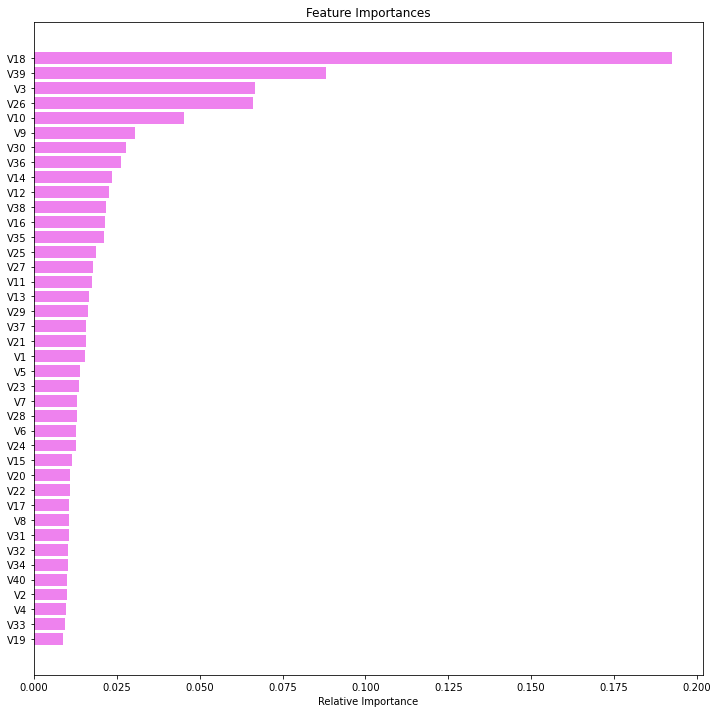

In [118]:
feature_names = X_test.columns
importances = xgb_tuned1.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

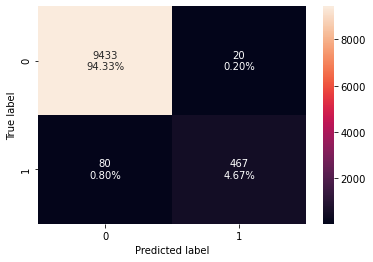

In [119]:
confusion_matrix_sklearn(xgb_tuned1, X_test, y_test)

## Pipelines to build the final model


* For numerical columns, we will do missing value imputation as pre-processing.
* We are doing missing value imputation for the whole data, so that if there is any missing value in the data in future that can be taken care of.

In [117]:
model = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        (
            "XGB",
            XGBClassifier(
               subsample=0.9 ,
               scale_pos_weight=10 ,
               n_estimators=100,
               random_state=1,
               learning_rate = 0.2 ,
                gamma = 0),
        ),
    ]
)
# Fit the model on training data
model.fit(X_train, y_train)

[02:56:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('imputer', SimpleImputer()),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=1, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=10, subsample=0.9,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

# Business Insights and Conclusions

* Our model shows that V18, V39, V2 and V26 predictors are the most important determinants for fairlure or no failure of a generator. 
* Maintenance costs from our model are around 25% higher than the minimum maintenance costs.
* If the model were to predict no failure, it is correct 99.8% of the time.
* If the model were to predict a failure, it is correct ,ie the generators have failed, 95.9% of the time.